In [1]:
import numpy as np
import scipy
from scipy.optimize import NonlinearConstraint, minimize

In [ ]:
# Generates the constraints in the pentagon feasible set.

norm_constraint = NonlinearConstraint(np.linalg.norm, lb = 0.9999, ub=1.0000)
def a1_hyperplane(x):
    return x[0] * (4 - 1.26) + x[1] * (0 - 3.79)

def a2_hyperplane(x):
    return x[0] * (1.26 + 3.2) + x[1] * (3.79 - 2.39)

def a3_hyperplane(x):
    return x[0] * (-3.2 + 3.28) + x[1] * (2.39 + 2.28)

def a4_hyperplane(x):
    return x[0] * (-3.28 - 1.13) + x[1] * (-2.28 + 3.83)

def a5_hyperplane(x):
    return x[0] * (1.13 - 4) + x[1] * (-3.83 - 0)

a1_constraint = NonlinearConstraint(a1_hyperplane, lb=0, ub=99)
a2_constraint = NonlinearConstraint(a2_hyperplane, lb=0, ub=99)
a3_constraint = NonlinearConstraint(a3_hyperplane, lb=0, ub=99)
a4_constraint = NonlinearConstraint(a4_hyperplane, lb=0, ub=99)
a5_constraint = NonlinearConstraint(a5_hyperplane, lb=0, ub=99)

params = [
    (a1_hyperplane, a1_constraint, (4, 0)),
    (a2_hyperplane, a2_constraint, (1.26, 3.79)),
    (a3_hyperplane, a3_constraint, (-3.2, 2.39)),
    (a4_hyperplane, a4_constraint, (-3.28, -2.28)),
    (a5_hyperplane, a5_constraint, (1.13, -3.83)),
]

A_mat = []
b_vec = []
for hyperplane, constraint, point in params:
    res = minimize(hyperplane, x0=[1,1], constraints=(norm_constraint, constraint))
    a = res['x']

    b = a[0] * point[0] + a[1] * point[1]
    A_mat.append(a)
    b_vec.append(b)

A_mat = np.array(A_mat)
b_vec = np.array(b_vec)
print(A_mat)
print(b_vec)


In [2]:
X1 = np.array([
    [4, 0],
    [1.26, 3.79],
])
X2 = np.array([
    [1.26, 3.79],
    [-3.2, 2.39],
])
X3 = np.array([
    [-3.2, 2.39],
    [-3.28, -2.28],
])
X4 = np.array([
    [-3.28, -2.28],
    [1.13, -3.83],
])
X5 = np.array([
    [1.13, -3.83],
    [4, 0],
])
Xs = [X1, X2, X3, X4, X5]
ones = np.array([1, 1])

A_mat = []
b_vec = -1 * np.ones(5)
for X in Xs:
    A_mat.append(np.linalg.solve(X, ones))
A_mat = np.array(A_mat)
A_mat = -1 * A_mat
print(A_mat)

[[-0.25       -0.18073879]
 [ 0.09247394 -0.29459556]
 [ 0.30855225 -0.00528569]
 [ 0.10238592  0.29130446]
 [-0.25        0.18733681]]


In [3]:
all_pts = [[4, 0], [1.26, 3.79], [-3.2, 2.39], [-3.28, -2.28], [1.13, -3.83]]
for pt in all_pts:
    print(np.dot(A_mat, pt))
    print(np.dot(A_mat, pt) >= -1)


[-1.          0.36989577  1.234209    0.40954369 -1.        ]
[ True  True  True  True  True]
[-1.         -1.          0.36874306  1.23305018  0.39500653]
[ True  True  True  True  True]
[ 0.3680343  -1.         -1.          0.36858271  1.24773499]
[ True  True False  True  True]
[ 1.23208443  0.36836334 -1.         -1.          0.39287206]
[ True  True  True  True  True]
[ 0.40972955  1.23279654  0.36890824 -1.         -1.        ]
[ True  True  True  True  True]


In [4]:
init_pt = 0.5 * np.array([4, 0]) + 0.5 * np.array([1.26, 3.79])

def direction_sample_helper(con):
    ''' Samples a random point from the unit ball then checks with
    the a vector that con'pt > 0
    '''
    wrong_direction = 1
    while wrong_direction == 1:
        pt = np.random.rand(2) - 0.5
        pt = pt / np.linalg.norm(pt)
        if np.dot(con, pt) >= 0:
            wrong_direction = 0
    return pt

def direction_sample(A_mat, bd_pt):
    ''' First identifies the relevant constraint on the boundary,
    then calls sample helper.
    '''
    ind = list(np.isclose(np.dot(A_mat, bd_pt), -1)).index(True)
    con = A_mat[ind]
    return direction_sample_helper(con)

def get_next_bd_pt(A_mat, bd_pt, dir_pt):
    ''' First removes boundary constraints, then finds nearest
    boundary.
    '''
    weights = np.array([(-1 - np.dot(ai, bd_pt)) / np.dot(ai, dir_pt) for ai in A_mat])
    weights[weights <= 0] = 99
    weight = min(weights)

    return bd_pt + weight * dir_pt


#r = direction_sample(A_mat, init_pt)
#bd_pt = get_next_bd_pt(A_mat, init_pt, r)
#print(bd_pt)
#print(np.dot(A_mat, bd_pt))
#print(np.dot(A_mat, bd_pt) >= -1.0001)

In [5]:
init_pt = 0.5 * np.array([4, 0]) + 0.5 * np.array([1.26, 3.79])

def shake_n_bake(A_mat, init_pt, n=10):
    '''
    1. randomly sample direction vector (r)
    2. randomly sample magnitude (xi)
    3. add infeasible point (y - xi * r, y)
    4. get next boundary point
    '''
    dataset = []
    bd_pt = init_pt
    while len(dataset) < n:
        r = direction_sample(A_mat, bd_pt)
        xi = np.random.exponential()
        infeas_pt = bd_pt - xi * r
        dataset.append((infeas_pt, bd_pt))
        bd_pt = get_next_bd_pt(A_mat, bd_pt, r)
    return dataset

dataset = shake_n_bake(A_mat, init_pt, n=500)


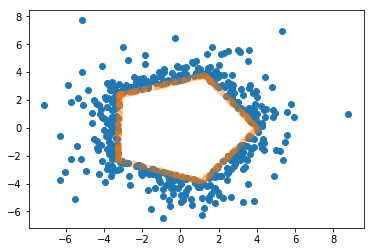

In [8]:
import matplotlib.pyplot as plt

infeas_pts, bd_pts = zip(*dataset)
x, y = zip(*infeas_pts)

plt.scatter(x, y)

x2, y2 = zip(*bd_pts)
plt.scatter(x2, y2, alpha=0.1)


In [13]:
print(list(range(-10, 11, 5)))


[-10, -5, 0, 5, 10]
